# Tennis Environment

In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
from unityagents import UnityEnvironment
import numpy as np
from datetime import datetime

In [3]:
env = UnityEnvironment(
    file_name="./Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [4]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


# Algorithm

For this project, I used the MADDPG decribed in the [Multi-Agent Actor-Critic for Mixed Cooperative-Competitive Environments](https://arxiv.org/pdf/1706.02275.pdf) paper.

![maddpg](./MADDPG_algorithm.png)




## Hyperparameters

In [6]:
args = {
    'num_agents': 2,
    'state_dim': [24, 24],
    'action_dim': [2, 2],
    'max_action': 1,
    'max_len': int(1e6),
    'update_freq': 1,
    'tau': 0.01,
    'gamma': 0.99,
    'batch_size': 100,
    'actor_lr': 1e-3,
    'critic_lr': 1e-3,
    'noise_scale': 0.1,
    'noise_theta': 0.2,
    'noise_sigma': 0.2,
}

## Agents' Actor and Critic Network Architecture

In [7]:
from MADDPG import MADDPG
multiagent = MADDPG(args)

The value of states can range a lot, so we are adding batch normalization to Actor before each fully connected layer. We also batch normalize state in the Critic, before joining it with actions.

In [8]:
multiagent.agents[1].actor

Actor(
  (network): Sequential(
    (0): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=24, out_features=256, bias=True)
    (2): ReLU()
    (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Linear(in_features=256, out_features=2, bias=True)
    (8): Tanh()
  )
)

In [9]:
# the critic has access to all agents' state and action
multiagent.agents[1].critic

Critic(
  (normalize_state): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (network): Sequential(
    (0): Linear(in_features=52, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [10]:
# reset environment
env_info = env.reset(train_mode=True)[brain_name] 
state, done = env_info.vector_observations, False

# total reward of an episode for all agents
episode_reward = np.zeros(args['num_agents'])
# number of timesteps within an episode
episode_timesteps = 0
# numer of episodes
episode_num = 0
# list of total rewards of each episode (max of the two agens)
scores = []

print_every = 100

max_timesteps = 1e6
start_timesteps = 3e4

start = datetime.now()
for t in range(int(max_timesteps)):
    
    episode_timesteps += 1
    
    if t < start_timesteps:
        action = np.random.uniform(low=-1,high=1,size=args['action_dim'])
    else:
        action = multiagent.sample_action(state, noise=1)
    
    env_info = env.step(action)[brain_name]
    
    next_state = env_info.vector_observations
    reward = env_info.rewards
    done = env_info.local_done           
    
    multiagent.add_experience(state, action, reward, next_state, done)

    
    state = next_state
    episode_reward += reward

    if t > start_timesteps and t % args['update_freq']  == 0:
        multiagent.train()
    
    if any(done):
        
        # reset environment
        env_info = env.reset(train_mode=True)[brain_name] 
        state, done = env_info.vector_observations, False
        
        episode_num += 1
        scores.append(np.max(episode_reward))
        
        if episode_num % print_every == 0:
            rolling_avg = np.mean(scores[-print_every:])
            time_spent = (datetime.now() - start).seconds
            print(f"Episode {episode_num}, Timestep: {t}, Last {print_every} Eps Avg Reward: {rolling_avg:.04f}, Time (sec): {time_spent} ")
            start = datetime.now()
            if rolling_avg > 0.7:
                break
        
        episode_reward = np.zeros(args['num_agents'])
        episode_timesteps = 0    

Episode 100, Timestep: 1932, Last 100,  Eps Avg Reward: 0.0224, Time (sec): 4 
Episode 200, Timestep: 3673, Last 100,  Eps Avg Reward: 0.0118, Time (sec): 3 
Episode 300, Timestep: 5528, Last 100,  Eps Avg Reward: 0.0184, Time (sec): 4 
Episode 400, Timestep: 7254, Last 100,  Eps Avg Reward: 0.0158, Time (sec): 4 
Episode 500, Timestep: 9109, Last 100,  Eps Avg Reward: 0.0200, Time (sec): 4 
Episode 600, Timestep: 10944, Last 100,  Eps Avg Reward: 0.0174, Time (sec): 5 
Episode 700, Timestep: 12773, Last 100,  Eps Avg Reward: 0.0194, Time (sec): 5 
Episode 800, Timestep: 14526, Last 100,  Eps Avg Reward: 0.0156, Time (sec): 4 
Episode 900, Timestep: 16371, Last 100,  Eps Avg Reward: 0.0193, Time (sec): 5 
Episode 1000, Timestep: 18100, Last 100,  Eps Avg Reward: 0.0116, Time (sec): 5 
Episode 1100, Timestep: 19842, Last 100,  Eps Avg Reward: 0.0145, Time (sec): 5 
Episode 1200, Timestep: 21698, Last 100,  Eps Avg Reward: 0.0190, Time (sec): 5 
Episode 1300, Timestep: 23616, Last 100,  

In [11]:
multiagent.save()
# multiagent = MADDPG(args)
# multiagent.load()

# Results

During the intial 30000 timesteps (roughly 1700 episodes), the agent is acting on uniformly sampled actions.   
Starting from timestep 30000, it trains on experiences tuple saved in the replay buffer

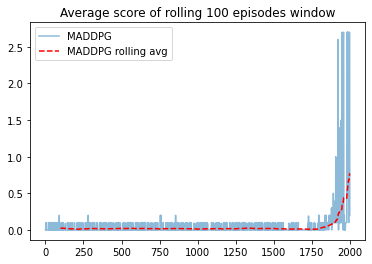

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd


plt.plot(scores, label='MADDPG', alpha=0.5)
plt.plot(pd.Series(scores).rolling(100).mean(), '--', label='MADDPG rolling avg', color='red')
plt.title('Average score of rolling 100 episodes window')
plt.legend()
plt.show()

The agent started training on experience tuple around episode 1700. By episode 2000, the last 100 episode's average score is 0.77

# Watch the Agents Play

In [17]:
env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
score = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:

    actions = multiagent.sample_action(states) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    score += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones): 
        # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(score)))

Total score (averaged over agents) this episode: 2.600000038743019


In [19]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
score = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:

    actions = multiagent.sample_action(states) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    score += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones): 
        # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(score)))

Total score (averaged over agents) this episode: 2.650000039488077


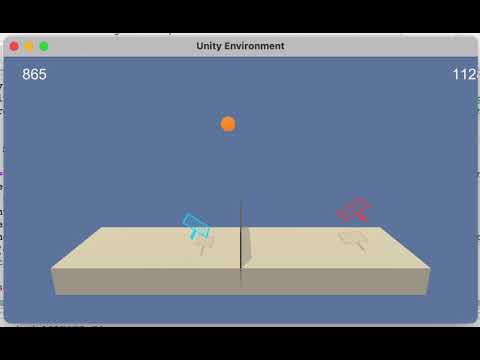

In [21]:
# https://youtu.be/LOTFwcljYbw

from IPython.display import YouTubeVideo
YouTubeVideo('LOTFwcljYbw')

# Future Improvements

Given that the two agents' critics are trying to learn the same thing (the value of all agents states, all agents actions), can we build one critic and share it across agents?

This [blog post](https://medium.com/brillio-data-science/improving-openai-multi-agent-actor-critic-rl-algorithm-27719f3cafd4) mentioned that using (all agents' states, all other agents' action) in the first layer of of critic network, and adding acting agent's action in the second layer stablize the training. I would like to implement this in the future.

